# Project v0.4

## Setup

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [2]:
print(tf.__version__)


2.8.0


## Parameters

In [3]:
# Define some parameters for the loader:

batch_size = 16
img_height = 256
img_width = 256

### Data path

In [4]:
import pathlib
data_dir = pathlib.Path("./data")
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

822


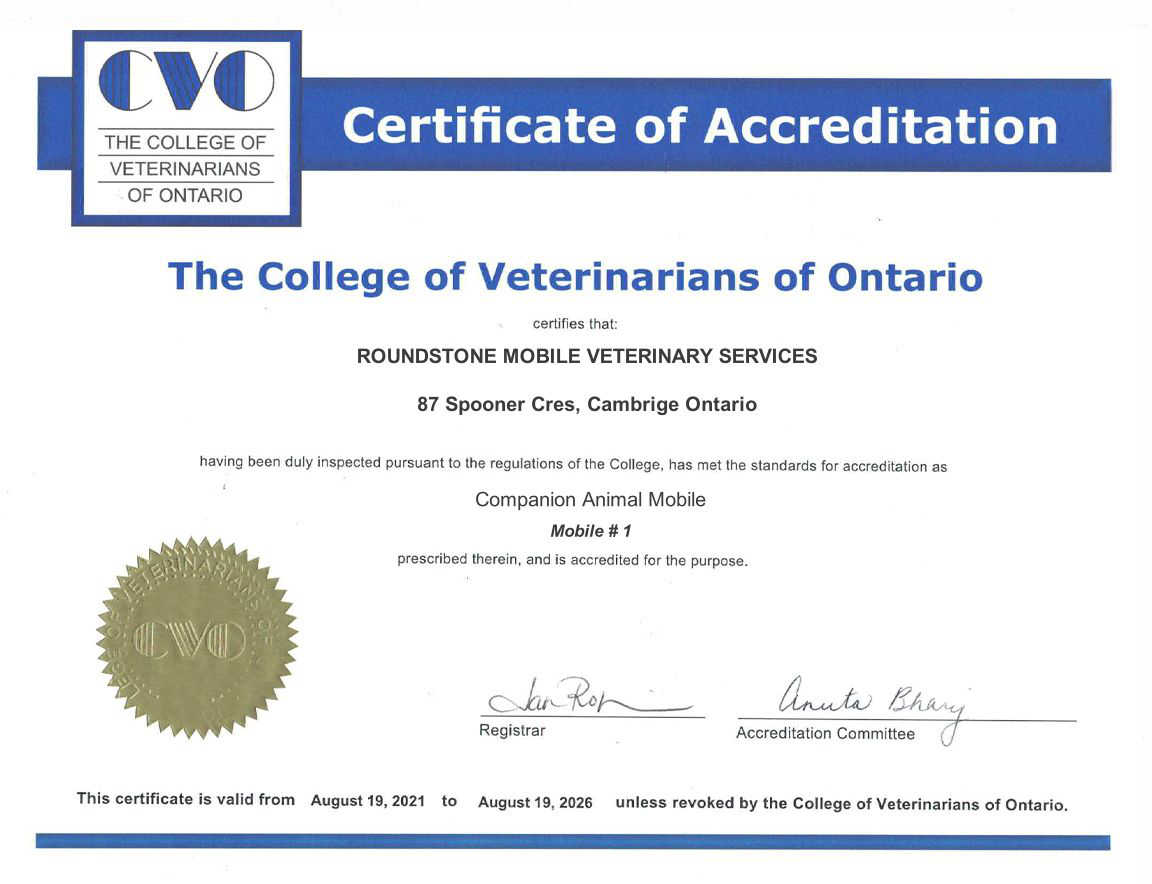

In [5]:
canada_ontario_cvo_imgs = list(data_dir.glob('canada_ontario_cvo/*'))
PIL.Image.open(str(canada_ontario_cvo_imgs[0]))

## Load data using a Keras utility

### Create a dataset

In [6]:
# training/validation split

train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=0,
  image_size=(img_height, img_width),
  batch_size=batch_size)

val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=0,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 822 files belonging to 2 classes.
Using 658 files for training.
Found 822 files belonging to 2 classes.
Using 164 files for validation.


In [7]:
# classes check

class_names = train_ds.class_names
print(class_names)

['canada_ontario_cvo', 'none']


### Data visualization

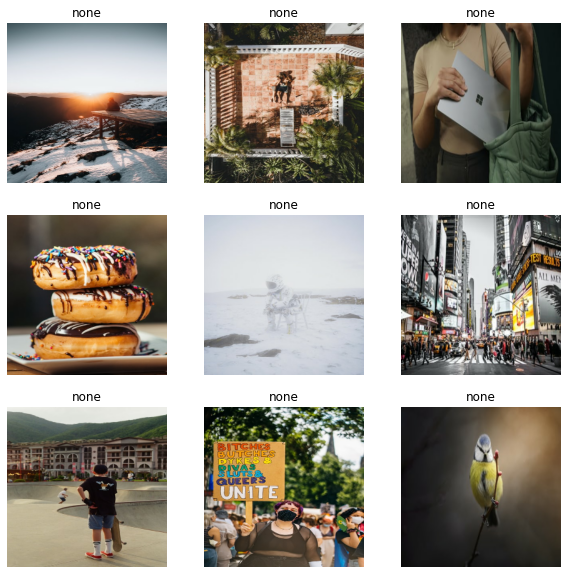

In [8]:
# plot first images from training set

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [9]:
# training batches info

for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(16, 256, 256, 3)
(16,)


### Dataset config for performance

In [10]:
# Cache images to improve performance

AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Data Preprocessing

In [11]:
# resizing and rescaling layers

resize_and_rescale = Sequential([
  layers.Resizing(img_height, img_width, input_shape=(img_height, img_width, 3)),
  layers.Rescaling(1./255)
])

### Data Augmentation

In [12]:
# data augmentation layers

data_augmentation = Sequential(
  [
    layers.RandomRotation(0.05),
    layers.RandomZoom(0.05),
  ]
)

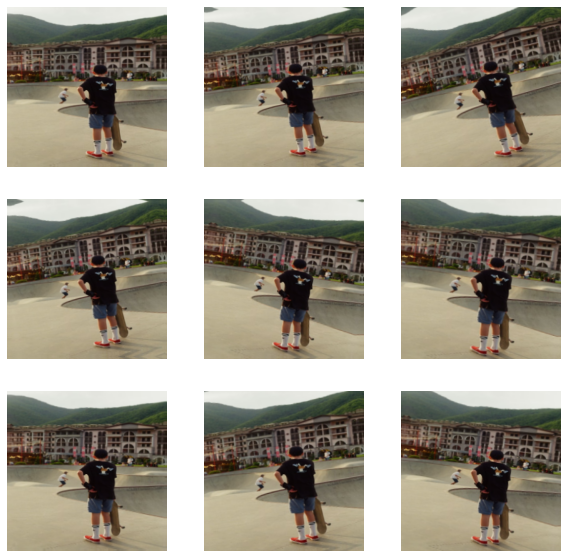

In [13]:
# augmentation example visualization

plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

### Model training

In [14]:
# Sequential model of three convolution blocks  with a max pooling layer

num_classes = len(class_names)

model = Sequential([
  resize_and_rescale,
  data_augmentation,
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [15]:
# config to view training and validation accuracy for each training epoch

model.compile(
  optimizer='adam',
  loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

In [16]:
# model summary

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 256, 256, 3)       0         
                                                                 
 sequential_1 (Sequential)   (None, 256, 256, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 256, 256, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 128, 128, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 64, 64, 32)       0         
 2D)                                                  

In [17]:
# training

class_weight = {0: 1, 1: 0.1}

epochs = 10
history = model.fit(
  train_ds,
  class_weight=class_weight,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
42/42 [==============================] - 17s 383ms/step - loss: 0.1966 - accuracy: 0.8708 - val_loss: 0.2235 - val_accuracy: 0.8841
Epoch 2/10
42/42 [==============================] - 15s 354ms/step - loss: 0.0458 - accuracy: 0.9468 - val_loss: 1.3596 - val_accuracy: 0.9817
Epoch 3/10
42/42 [==============================] - 16s 384ms/step - loss: 0.1070 - accuracy: 0.9301 - val_loss: 0.1581 - val_accuracy: 0.9146
Epoch 4/10
42/42 [==============================] - 15s 362ms/step - loss: 0.0365 - accuracy: 0.9529 - val_loss: 0.0030 - val_accuracy: 1.0000
Epoch 5/10
42/42 [==============================] - 15s 351ms/step - loss: 0.0028 - accuracy: 0.9985 - val_loss: 0.0276 - val_accuracy: 0.9939
Epoch 6/10
42/42 [==============================] - 14s 343ms/step - loss: 0.0014 - accuracy: 0.9954 - val_loss: 3.9986e-04 - val_accuracy: 1.0000
Epoch 7/10
42/42 [==============================] - 16s 376ms/step - loss: 1.6885e-06 - accuracy: 1.0000 - val_loss: 1.4160e-04 - val_accu

### Visualize training results

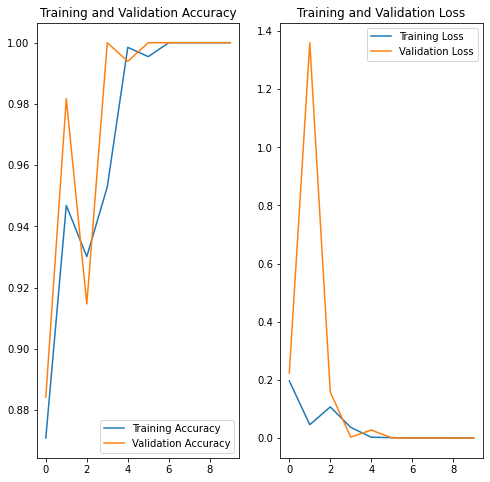

In [18]:
# Create plots of loss and accuracy on the training and validation sets:

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# let's try and predict on a none image

This image most likely belongs to none with a 100.00 percent confidence.


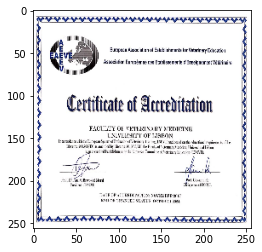

In [19]:
img_path = "./test_data/none_test_2.jpg"

img = tf.keras.utils.load_img(
    img_path, target_size=(img_height, img_width)
)
plt.imshow(img)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

# let's try and predict on a canada_ontario_cvo image

This image most likely belongs to canada_ontario_cvo with a 100.00 percent confidence.


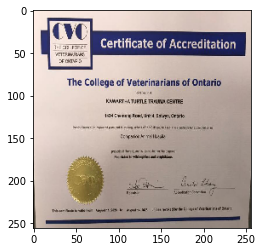

In [20]:
img_path = "./test_data/canada_ontario_cvo_test_2.jpg"

img = tf.keras.utils.load_img(
    img_path, target_size=(img_height, img_width)
)
plt.imshow(img)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)